In [549]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import jax.numpy as jnp
from jax import grad , vmap
from matplotlib.colors import LogNorm
from ipywidgets import interact, IntSlider
from jax.scipy.spatial.transform import Rotation as R

In [550]:
def _calculate_rho(x, y, z, e, p, q, rho0, s, a, b):
    r = ((jnp.abs(x)**(2 - e) + (jnp.abs(y) / p)**(2 - e) + (jnp.abs(z) / q)**(2 - e)))**(1 / (2 - e))
    den = rho0 / ((r / s)**a * (1 + (r / s))**(b - a))
    return den

def rho(x, y, z, e, p, q, rho0, s, a, b):
    # Convert inputs to arrays
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    z = jnp.asarray(z)

    # Check if inputs are arrays or scalars
    if x.ndim == 0:  # Scalar input
        return _calculate_rho(x, y, z, e, p, q, rho0, s, a, b)
    else:  # Array input
        # Check if inputs have the same length
        if x.size != y.size or x.size != z.size or y.size != z.size:
            raise ValueError("Input arrays must have the same length!")
        
        # Check if the length of inputs is reshapeable into a cube
        cube_len = int(round(x.size ** (1/3)))
        if cube_len ** 3 != x.size:
            raise ValueError("The length of the inputs must be reshapeable into a cube!")

        return _calculate_rho(x, y, z, e, p, q, rho0, s, a, b).reshape((cube_len, cube_len, cube_len))

In [551]:
def _calculate_gradient_rho(x, y, z, e, p, q, rho0, s, a, b, arg_num):
    grad_rho = grad(rho, argnums=arg_num)
    return grad_rho(x, y, z, e, p, q, rho0, s, a, b)

def gradient_rho(x, y, z, e, p, q, rho0, s, a, b, arg_num):
    # Convert inputs to arrays
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    if not arg_num:
        raise ValueError("arg_num cannot be empty. Specify the arguments to differentiate with respect to.")
    
    # Check if inputs are arrays or scalars
    if x.ndim == 0:  # Scalar input
        return _calculate_gradient_rho(x, y, z, e, p, q, rho0, s, a, b, arg_num)
    else:  # Array input
        # Check if inputs have the same length
        if x.size != y.size or x.size != z.size or y.size != z.size:
            raise ValueError("Input arrays must have the same length!")
        
        # Define the function to compute the gradient
        grad_rho = grad(rho, argnums=arg_num)

        # Vectorize the gradient function
        vmap_grad_rho = vmap(lambda x, y, z: grad_rho(x, y, z, e, p, q, rho0, s, a, b), in_axes=(0, 0, 0))

        # Compute the gradients
        gradients = vmap_grad_rho(x, y, z)

        # Reshape and stack the gradients
        cube_len = int(round(x.size ** (1/3)))
        reshaped_gradients = [jnp.reshape(g, (cube_len, cube_len, cube_len)) for g in gradients]

        # Stack gradients along the last axis
        stacked_gradients = jnp.stack(reshaped_gradients, axis=-1)
        
        return stacked_gradients

In [552]:
def rotation(x,y,z,angle,axis):

    x = jnp.asarray(x)
    y = jnp.asarray(y)
    z = jnp.asarray(z)

    if(x.size!= y.size or x.size!= z.size or y.size!= z.size):
        raise ValueError("Input must have the same length!")

    if axis not in ['x', 'y', 'z']:
        raise ValueError("axis has to be either x , y or z!")
    
    rotation = R.from_euler(axis, angle, degrees=True)

    coordinates = jnp.array([x, y, z]).T
    
    rotated_coordinates = rotation.apply(coordinates)

    res = rotated_coordinates.T
    
    x_rot, y_rot, z_rot = res[0], res[1], res[2]

    return x_rot, y_rot, z_rot

    

In [553]:
def plot_img(proj_density_mat, extent, title = '' ):
    plt.imshow(proj_density_mat.T, origin= 'lower', extent=extent)
    plt.colorbar(label='Color Scale')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.show()

In [554]:
s = 1. 
e = 0.
p = 0.8
q = 0.6
a = 2.
b = 4.
rho0 = 0.001


# Define the size of your 3D matrix
x_size, y_size, z_size = 10, 10, 10

# Create 3D coordinates
x, y, z = np.meshgrid(np.linspace(-0.01, 0.01, x_size),
                      np.linspace(-0.01, 0.01, y_size),
                      np.linspace(-0.01, 0.01, z_size), indexing = 'ij')
x = x.flatten()
y = y.flatten()
z = z.flatten()

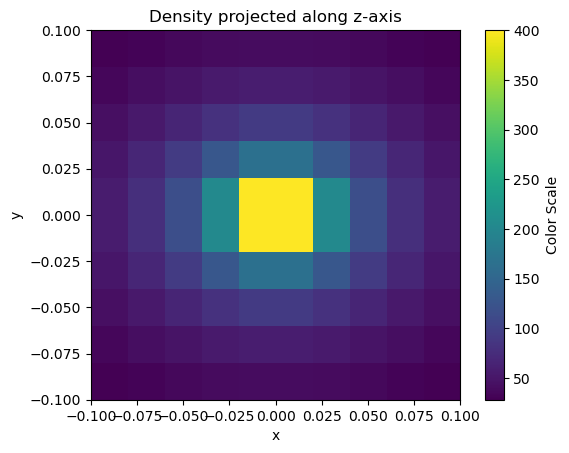

In [555]:
density = rho(x,y,z,e,p,q,rho0,s,a,b)

density = np.sum(density, axis = 2)
extent = [-0.1,0.1,-0.1,0.1]
plot_img(density, extent, 'Density projected along z-axis')

In [556]:
density1 = rho(x[0],y[0],z[0],e,p,q,rho0,s,a,b)
density1

Array(1.788926, dtype=float32)

In [557]:
list_args = [0,1,2,3,4,5]
gradient_01 = gradient_rho(x,y,z,e,p,q,rho0,s,a,b,list_args)

In [558]:
gradx = gradient_01[:,:,:,0]
gradx = np.sum(gradx, axis=2)
grady = gradient_01[:,:,:,1]
grady = np.sum(grady, axis=2)
gradz = gradient_01[:,:,:,2]
gradz = np.sum(gradz, axis=2)
grade = gradient_01[:,:,:,3]
grade = np.sum(grade, axis=2)
gradp = gradient_01[:,:,:,4]
gradp = np.sum(gradp, axis=2)
gradq = gradient_01[:,:,:,5]
gradq = np.sum(gradq, axis=2)

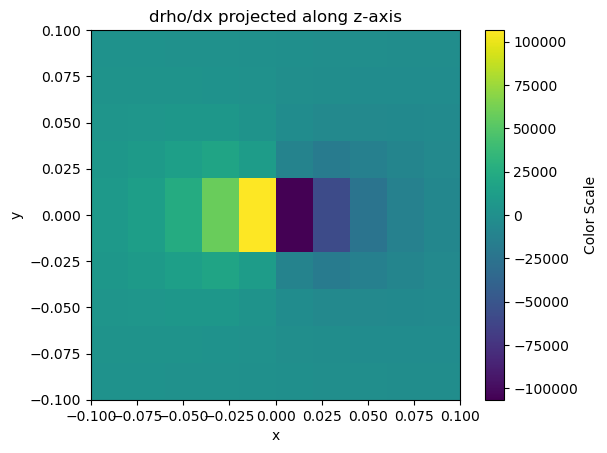

In [559]:
plot_img(gradx,extent, 'drho/dx projected along z-axis')

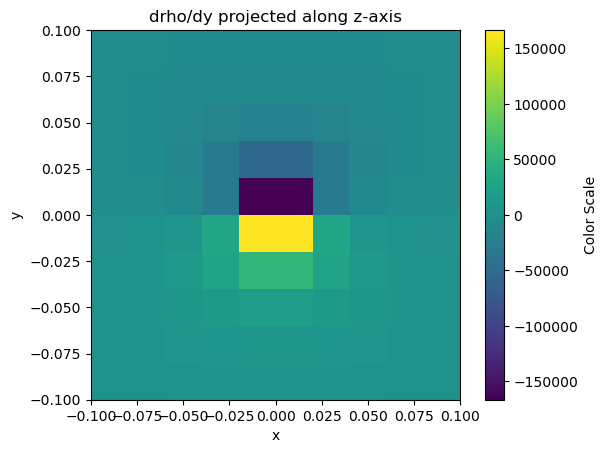

In [560]:
plot_img(grady,extent, 'drho/dy projected along z-axis')

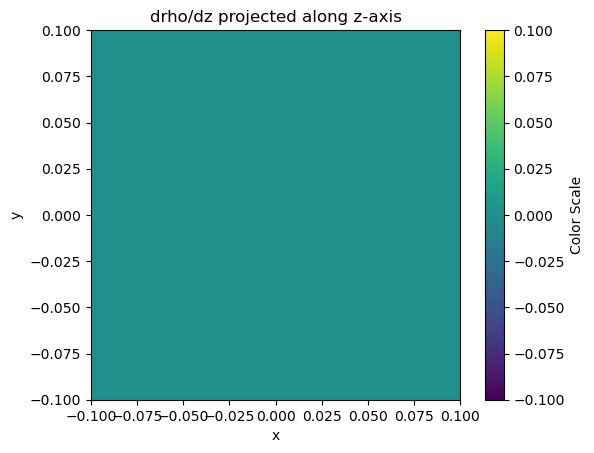

In [561]:
plot_img(gradz,extent, 'drho/dz projected along z-axis')

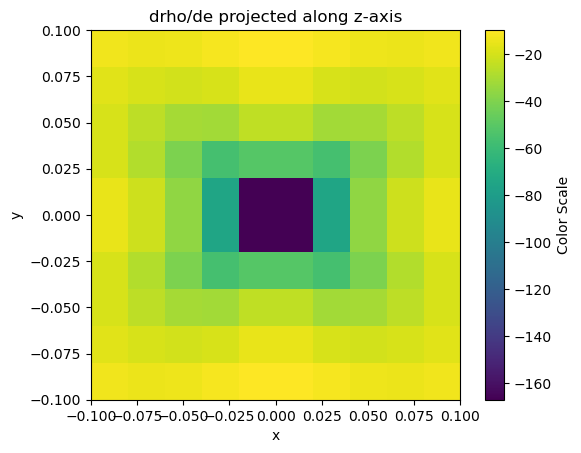

In [562]:
plot_img(grade,extent, 'drho/de projected along z-axis')
# Only works while using abs on x,y,z

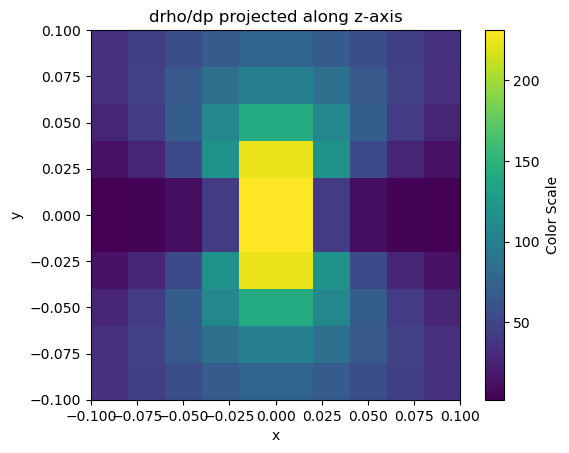

In [563]:
plot_img(gradp,extent, 'drho/dp projected along z-axis')

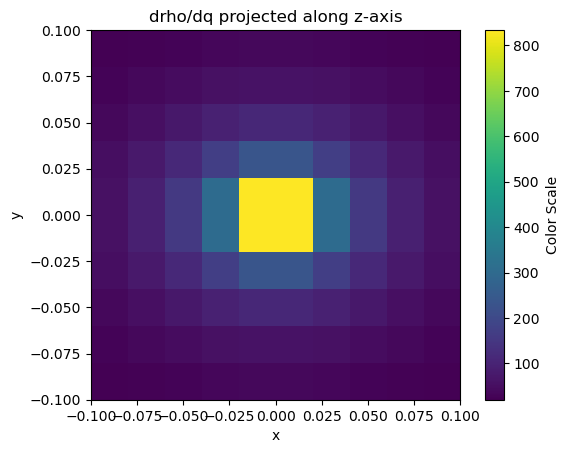

In [564]:
plot_img(gradq,extent, 'drho/dq projected along z-axis')

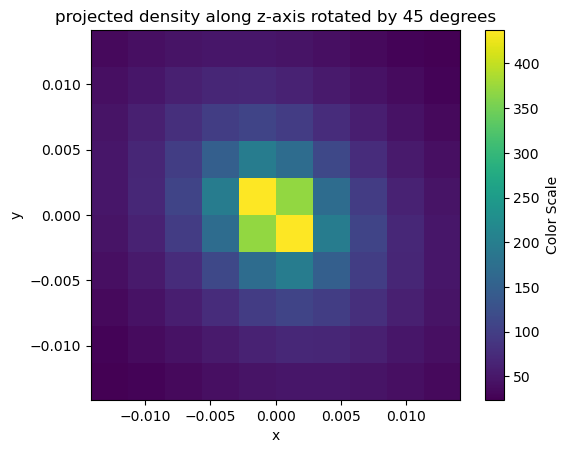

In [565]:
rot_x , rot_y , rot_z = rotation(x,y,z,45,'z')

rot_density = rho(rot_x,rot_y,rot_z,e,p,q,rho0,s,a,b)

rot_density = np.sum(rot_density, axis = 2)

extent = [np.min(rot_x),np.max(rot_x),np.min(rot_y),np.max(rot_y)]
plot_img(rot_density,extent, 'projected density along z-axis rotated by 45 degrees')